In [1]:
import pandas as pd

In [2]:
train_df=pd.read_csv('merged_training_dataset.csv')

In [3]:
test_df=pd.read_csv('merged_dataset_test.csv')

In [4]:
import pandas as pd

numeric_df = train_df.select_dtypes(include=[float, int])

corr_matrix = numeric_df.corr()
risk_corr = corr_matrix['risk_score'].sort_values(ascending=False)

print(risk_corr)


risk_score                       1.000000
type_SCREENING                   0.512569
subtype_COLORECTAL CANCER        0.503465
count_msrmnt_type                0.485633
num_care_gaps                    0.476264
num_care_events                  0.476264
weighted_care_score              0.471196
hotspot_recency_norm             0.468084
has_last_care                    0.455722
num_inpatient_visits             0.445725
num_follow_ups                   0.423460
num_chronic_conditions           0.377092
has_next_care                    0.359496
chronic_condition_ratio          0.322784
subtype_BREAST CANCER            0.319332
msrmnt_subtype_diversity         0.306551
age                              0.292966
inpatient_visit_ratio            0.290642
num_visits                       0.285180
diabetes_count.1                 0.284086
diabetes_count                   0.284086
followup_ratio                   0.283594
hypertension_count               0.280926
num_er_visits                    0

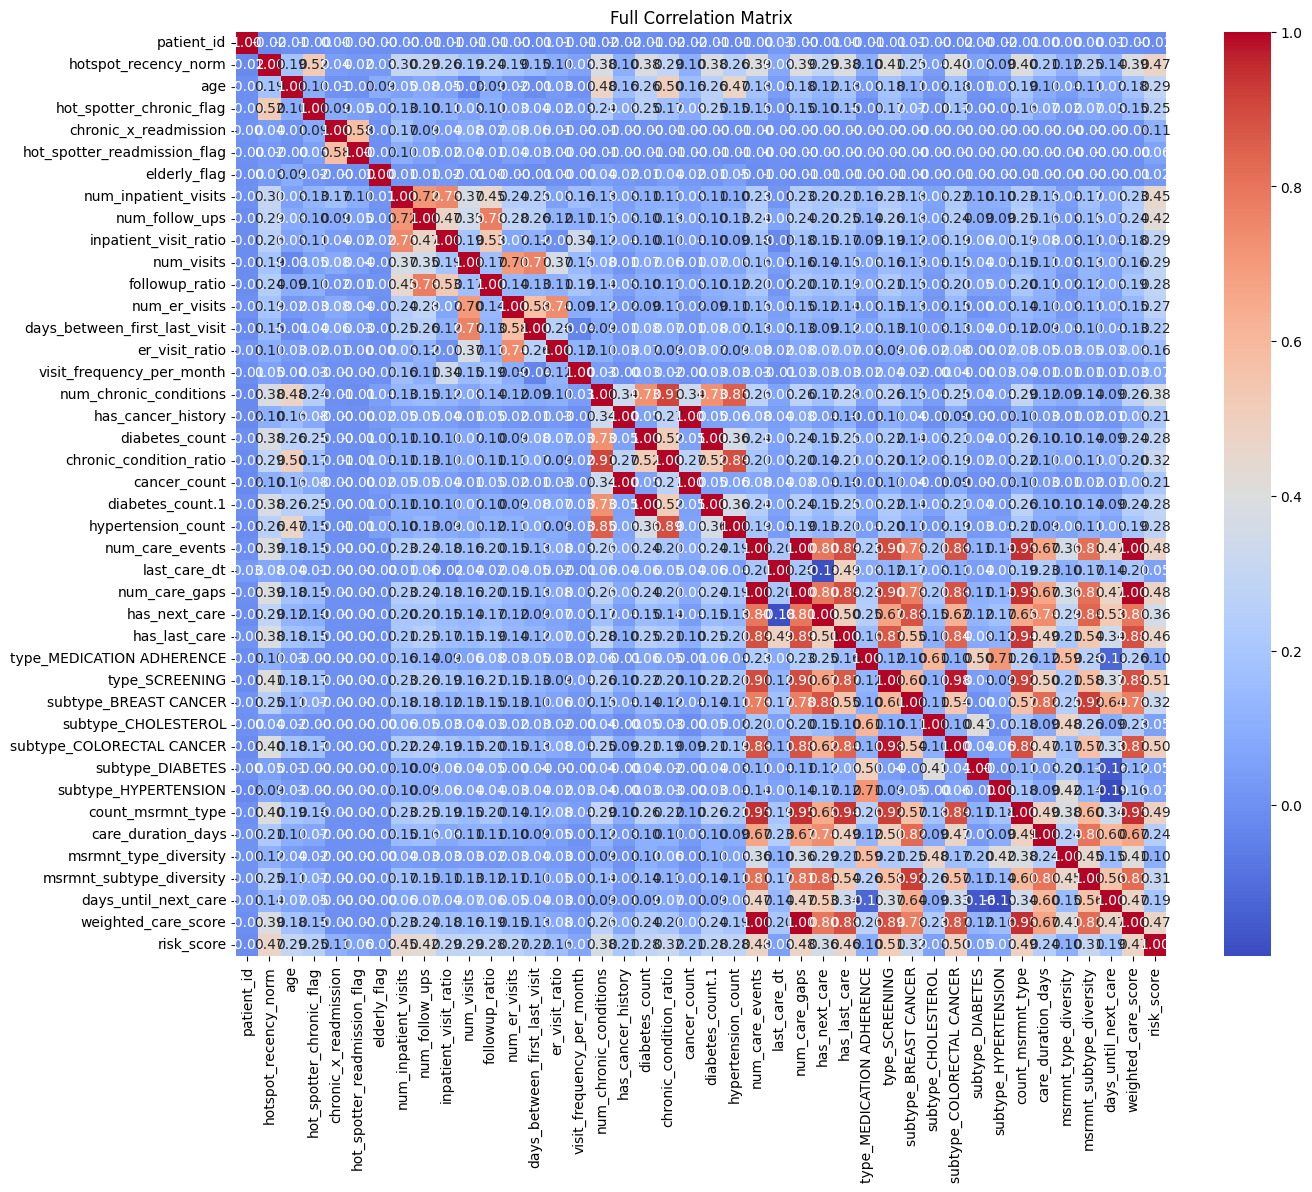

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15,12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Full Correlation Matrix")
plt.show()


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib           
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Add, Multiply
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
SEED = 42
np.random.seed(SEED)
import tensorflow as tf
tf.random.set_seed(SEED)


In [7]:
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (8000, 43)
Test shape: (2001, 42)


In [25]:

X_raw = train_df.drop(columns=['risk_score']).copy()
y = train_df['risk_score'].values


for col in X_raw.select_dtypes(include='object').columns:
    X_raw[col] = X_raw[col].map({'t':1, 'f':0, 'True':1, 'False':0}).fillna(0)

X_raw = X_raw.fillna(0)


train_feature_cols = X_raw.columns.tolist()

joblib.dump(train_feature_cols, "train_feature_cols.joblib")
print("Training features:", len(train_feature_cols))


Training features: 42


In [26]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)
joblib.dump(scaler, "scaler.joblib")

pca = PCA(n_components=0.95, random_state=SEED)
X_pca = pca.fit_transform(X_scaled)
joblib.dump(pca, "pca.joblib")

print("Original features:", X_raw.shape[1])
print("PCA comps:", X_pca.shape[1])
print("Explained variance:", pca.explained_variance_ratio_.sum().round(4))


Original features: 42
PCA comps: 21
Explained variance: 0.9507



-----------------------------
Training Fold 1/5
-----------------------------
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Fold 1 — R²: 0.444, RMSE: 1.839

-----------------------------
Training Fold 2/5
-----------------------------
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Fold 2 — R²: 0.534, RMSE: 1.609

-----------------------------
Training Fold 3/5
-----------------------------
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 3 — R²: 0.473, RMSE: 1.775

-----------------------------
Training Fold 4/5
-----------------------------
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 4 — R²: 0.456, RMSE: 2.064

-----------------------------
Training Fold 5/5
-----------------------------
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 5 — R²: 0.471, RMSE: 1.807

Cross-validation results
Mean R²:   0.476 ± 0.031
Mean RMSE: 1.819 ± 0.146


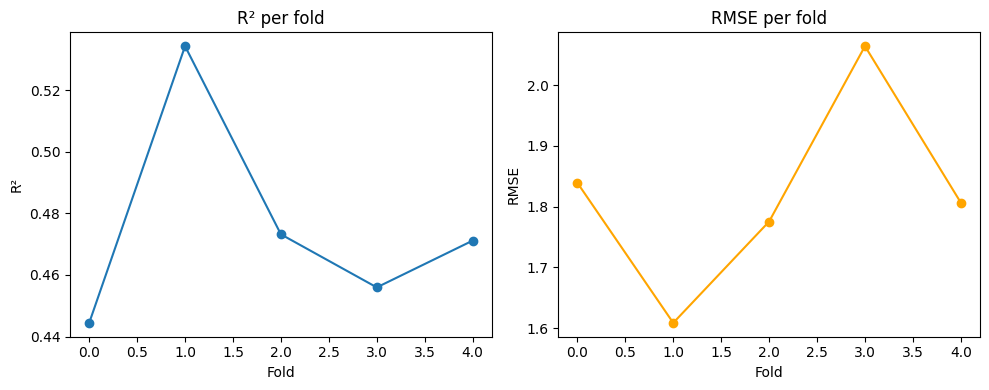

In [27]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Add, Multiply
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def build_residual_attention_nn(input_dim):
    inputs = Input(shape=(input_dim,))

    x = Dense(256, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x1 = Dense(256, activation='relu')(x)
    x1 = BatchNormalization()(x1)
    x1 = Dropout(0.3)(x1)
    x1 = attention_block(x1, 256)
    x = Add()([x, x1])

    x2 = Dense(256, activation='relu')(x)
    x2 = BatchNormalization()(x2)
    x2 = Dropout(0.3)(x2)
    x2 = attention_block(x2, 256)
    x = Add()([x, x2])

    x3 = Dense(256, activation='relu')(x)
    x3 = BatchNormalization()(x3)
    x3 = Dropout(0.2)(x3)
    x3 = attention_block(x3, 256)
    x = Add()([x, x3])

    x = Dense(64, activation='relu')(x)
    outputs = Dense(1, activation='linear')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(1e-3), loss='mse')
    return model


def attention_block(inputs, units):
    """Simple channel-wise attention"""
    x = Dense(units, activation='relu')(inputs)
    x = Dense(units, activation='sigmoid')(x)
    return Multiply()([inputs, x])


kfold = KFold(n_splits=5, shuffle=True, random_state=42)

r2_scores = []
rmse_scores = []

fold = 1
for train_idx, val_idx in kfold.split(X_pca):
    print(f"\n-----------------------------")
    print(f"Training Fold {fold}/5")
    print(f"-----------------------------")

    X_train, X_val = X_pca[train_idx], X_pca[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    model = build_residual_attention_nn(X_pca.shape[1])

    es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

    # Train
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=32,
        callbacks=[es],
        verbose=0
    )

    y_pred = model.predict(X_val)
    r2 = r2_score(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    r2_scores.append(r2)
    rmse_scores.append(rmse)

    print(f"Fold {fold} — R²: {r2:.3f}, RMSE: {rmse:.3f}")
    fold += 1

print("\n===============================")
print("Cross-validation results")
print("===============================")
print(f"Mean R²:   {np.mean(r2_scores):.3f} ± {np.std(r2_scores):.3f}")
print(f"Mean RMSE: {np.mean(rmse_scores):.3f} ± {np.std(rmse_scores):.3f}")

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(r2_scores, marker='o')
plt.title("R² per fold")
plt.xlabel("Fold")
plt.ylabel("R²")

plt.subplot(1,2,2)
plt.plot(rmse_scores, marker='o', color='orange')
plt.title("RMSE per fold")
plt.xlabel("Fold")
plt.ylabel("RMSE")

plt.tight_layout()
plt.show()


In [11]:
final_model = build_residual_attention_nn(X_pca.shape[1])
es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history_full = final_model.fit(
    X_pca, y,
    validation_split=0.1,  
    epochs=200,
    batch_size=32,
    callbacks=[es],
    verbose=1
)


final_model.save("final_residual_attention_model.keras")
print("Final model saved.")


Epoch 1/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 5.1526 - val_loss: 2.1794
Epoch 2/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.4101 - val_loss: 2.4917
Epoch 3/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.9009 - val_loss: 2.5986
Epoch 4/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.5788 - val_loss: 3.2393
Epoch 5/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.5035 - val_loss: 3.7668
Epoch 6/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.3366 - val_loss: 4.2048
Epoch 7/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.2968 - val_loss: 3.1452
Epoch 8/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.1168 - val_loss: 3.4355
Epoch 9/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.7752 - val_loss: 4.2717
Epoch 10/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.9203 - val_loss: 3.4996
Epoch 11/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.7386 - val_loss: 3.5948
Epoch 12/200
225/225 ━━━━━━━━━━━━━━━━━━━

In [12]:
X_test_raw = test_df.copy()


if 'patient_id' in X_test_raw.columns:
    test_patient_ids = X_test_raw['patient_id'].values
    X_test_raw = X_test_raw.drop(columns=['patient_id'])

for col in X_test_raw.select_dtypes(include='object').columns:
    X_test_raw[col] = X_test_raw[col].map({'t':1, 'f':0, 'True':1, 'False':0}).fillna(0)


X_test_raw = X_test_raw.fillna(0)


train_cols = joblib.load("train_feature_cols.joblib")  

missing_cols = [c for c in train_cols if c not in X_test_raw.columns]
for c in missing_cols:
    X_test_raw[c] = 0

extra_cols = [c for c in X_test_raw.columns if c not in train_cols]
if extra_cols:
    X_test_raw = X_test_raw.drop(columns=extra_cols)


X_test_raw = X_test_raw[train_cols]

print("Test features aligned. Shape:", X_test_raw.shape)


Test features aligned. Shape: (2001, 42)


In [13]:
scaler = joblib.load("scaler.joblib")
pca = joblib.load("pca.joblib")

X_test_scaled = scaler.transform(X_test_raw)   
X_test_pca = pca.transform(X_test_scaled)
print("Test PCA shape:", X_test_pca.shape)


Test PCA shape: (2001, 21)


In [14]:
from tensorflow.keras.models import load_model
model = load_model("final_residual_attention_model.keras")

preds = model.predict(X_test_pca).flatten()


out_df = pd.DataFrame({
    'patient_id': test_patient_ids if 'test_patient_ids' in locals() else np.arange(len(preds)),
    'predicted_risk_score': preds
})

out_df.to_csv("test_predictions.csv", index=False)
print("Predictions saved to test_predictions.csv. Shape:", out_df.shape)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Predictions saved to test_predictions.csv. Shape: (2001, 2)
